In [1]:
pip install git+https://github.com/jytan17/ML_Package

  Cloning https://github.com/jytan17/ML_Package to /tmp/pip-req-build-u5o8fqr3
  Running command git clone -q https://github.com/jytan17/ML_Package /tmp/pip-req-build-u5o8fqr3
  Created wheel for models: filename=models-0.0.1-py3-none-any.whl size=10752 sha256=a62a48dc086adcde66259d75a02e622a8b32c583248c6c7424681ca54e04757a
  Stored in directory: /tmp/pip-ephem-wheel-cache-tk6t1fw0/wheels/86/1e/15/211ddcc9a5029903108a973d95b54484032c8ef3a9ad350814
Successfully built models


## kNN

Below we will test our implementation of k nearest neighbours. The datasets used in this section can be downloaded at [https://github.com/jytan17/miscellaneous/tree/main/other/data_ml_package_ng](https://github.com/jytan17/miscellaneous/tree/main/other/data_ml_package_ng)

In [4]:
from models.supervised import knnClassifier
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
# some helper functions to plot 
def loaddata(filename):
    data = loadmat(filename)
    xTr = data["xTr"]; # load in Training data
    yTr = np.round(data["yTr"]); # load in Training labels
    xTe = data["xTe"]; # load in Testing data
    yTe = np.round(data["yTe"]); # load in Testing labels
    return xTr.T,yTr.T.flatten(),xTe.T,yTe.T.flatten()
    

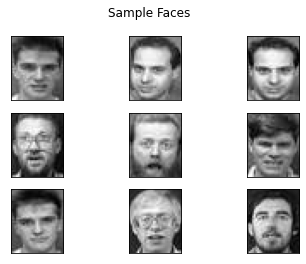

In [5]:
xTr,yTr,xTe,yTe=loaddata("faces.mat")

imgplot = lambda ax, x : ax.imshow(x.reshape(31, 38).T, cmap=plt.cm.binary_r)

fig, ax = plt.subplots(3, 3)
fig.suptitle("Sample Faces")
samples = np.random.choice(xTr.shape[0], 9).reshape(3,-1)
for i in range(3):
    for j in range(3):
        imgplot(ax[i, j], xTr[samples[i, j]])
        ax[i, j].xaxis.set_visible(False)
        ax[i, j].yaxis.set_visible(False)

Error Rate: 13.33 %


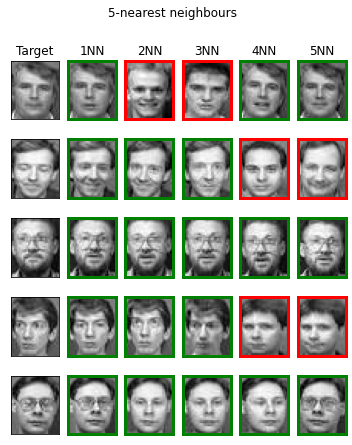

In [6]:
def visualize_knn(model, Xte, yte, img_plotter):
    n = Xte.shape[0]
    k = model.k
    indices, _ = model._findknn(Xte)
    indices = indices.T

    fig, ax = plt.subplots(n, k+1, figsize = (k + 1,n + 2))
    
    fig.suptitle(f"{k}-nearest neighbours")
    for i in range(n):
        for j in range(k+1):
            if j == 0:
                img_plotter(ax[i, j], Xte[i])
            else:
                img_plotter(ax[i, j], model.Xtr[indices[i, j-1]])

            color = "green" if yte[i] == model.ytr[indices[i, j-1]] else "red"
            if j != 0:
                for spine in ax[i, j].spines.values():
                    spine.set_color(color)
                    spine.set_linewidth(3)
            
            ax[i,j].yaxis.set_visible(False)
            ax[i,j].xaxis.set_visible(False)

            ax[i, j].set_title("Target") if (i == 0 and j == 0) else None
            ax[i, j].set_title(f"{j}NN") if (i == 0 and j != 0) else None


clf = knnClassifier(5)
clf.fit(xTr, yTr)
clf.score(xTe, yTe, verbose=True)
visualize_knn(clf, xTe[:5], yTe[:5], imgplot)

Error Rate: 5.48 %


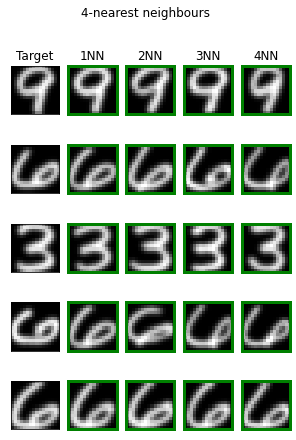

In [7]:
xTr,yTr,xTe,yTe=loaddata("digits.mat")

imgplot = lambda ax, x : ax.imshow(x.reshape(16, 16).T, cmap=plt.cm.binary_r)

clf = knnClassifier(4)
clf.fit(xTr, yTr)
clf.score(xTe, yTe, verbose=True)
visualize_knn(clf, xTe[:5], yTe[:5], imgplot)

## Trees and Forests

Below, we will conduct a few experiments to verify the implementations of our Tree algorithms, namely Classification and Regression Tree (CART), Random Forest (an ensemble method consists of CARTs), and Adaboost Trees (boosting with trees).

In [8]:
from models.supervised import CART, RandomForest, AdaboostTree
import numpy as np
from numpy.matlib import repmat
import matplotlib.pyplot as plt

In [9]:
def gen_spiral_data(N=300):
    "Generate a 2D non-linearly separable dataset"

    r = np.linspace(1,2*np.pi,N)
    xTr1 = np.array([np.sin(2.*r)*r, np.cos(2*r)*r]).T
    xTr2 = np.array([np.sin(2.*r+np.pi)*r, np.cos(2*r+np.pi)*r]).T
    xTr = np.concatenate([xTr1, xTr2], axis=0)
    yTr = np.concatenate([np.ones(N), -1 * np.ones(N)])
    xTr = xTr + np.random.randn(xTr.shape[0], xTr.shape[1])*0.2
    
    xTe = xTr[::2,:]
    yTe = yTr[::2]
    xTr = xTr[1::2,:]
    yTr = yTr[1::2]
    
    return xTr,yTr,xTe,yTe

def visualize_tree(model, Xtr, ytr):
    "A helper function to visualise out SVM's solution"
    symbols = ["ko", "kx"]
    marker_symbols = ['o', 'x']
    mycolors = [[0.5, 0.5, 1], [1, 0.5, 0.5]]
    labels = np.unique(ytr)

    res = 300
    x = np.linspace(Xtr[:, 0].min(), Xtr[:, 0].max(), res)
    y = np.linspace(Xtr[:, 1].min(), Xtr[:, 1].max(), res)

    X = repmat(x, res, 1)
    Y = repmat(y, res, 1).T
    Xte = np.array([X.flatten(), Y.flatten()]).T

    preds = model.predict(Xte)
    Z = preds.reshape(res, res)

    plt.contourf(X, Y, np.sign(Z), colors = mycolors)
    
    for idx, c in enumerate(labels):
        plt.scatter(Xtr[ytr == c, 0], 
                    Xtr[ytr == c, 1], 
                    marker=marker_symbols[idx], 
                    color='k')
        
    plt.axis('tight')
    plt.show()


A single tree's decision boundaries

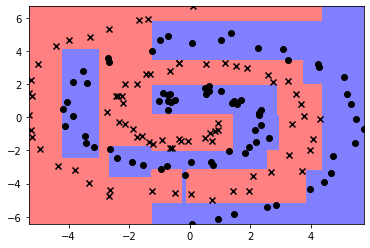

In [10]:
xTr, yTr, xTe, yTe = gen_spiral_data(150)
cart = CART()
cart.fit(xTr, yTr)
visualize_tree(cart, xTr, yTr)

A forest's decision boundaries

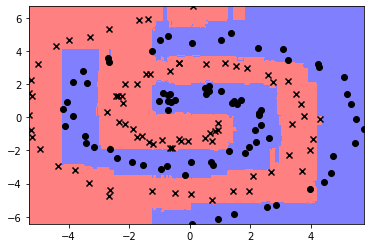

In [11]:
forest = RandomForest(maxiter=30)
forest.fit(xTr, yTr)
visualize_tree(forest, xTr, yTr)

Decision boundary of a forest, but with boosting

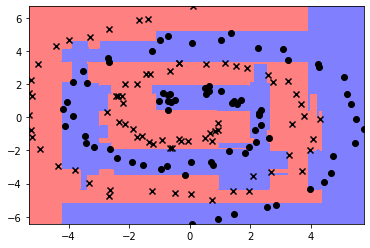

In [12]:
ada = AdaboostTree(maxiter = 100, maxdepth = 3)
ada.fit(xTr, yTr)
visualize_tree(ada, xTr, yTr)

## PCA and K means

### Experiment 1 (Iris Dataset)

Below we will visualise the Iris dataset with 4 features in a 2D plane by performing a dimensionality reduction with PCA. Then, we will use this to visualise if the K means implemenation were able to cluster the data correctly.

In [13]:
# import kMeans and PCA from our package
from models.unsupervised import kMeans, PCA
import numpy as np
import matplotlib.pyplot as plt

Load the Iris data (can be downloaded at [https://github.com/jytan17/miscellaneous/tree/main/other/data_ml_package_ng](https://github.com/jytan17/miscellaneous/tree/main/other/data_ml_package_ng))

In [14]:
def load_data():
    data = np.load('iris.npy')
    return data[:,:-1], data[:,-1]

X_iris, y_iris = load_data()
N, data_dim = X_iris.shape
y_iris_colors = np.char.add(np.array(["C"]), y_iris.astype(int).astype(str))

In [15]:
pca = PCA(2)
pca.fit(X_iris)
kmeans = kMeans(3)
kmeans.fit(X_iris)
y_kmeans = kmeans.predict(X_iris)
Y_kmeans_colors = np.char.add(np.array(["C"]), y_kmeans.astype(str))

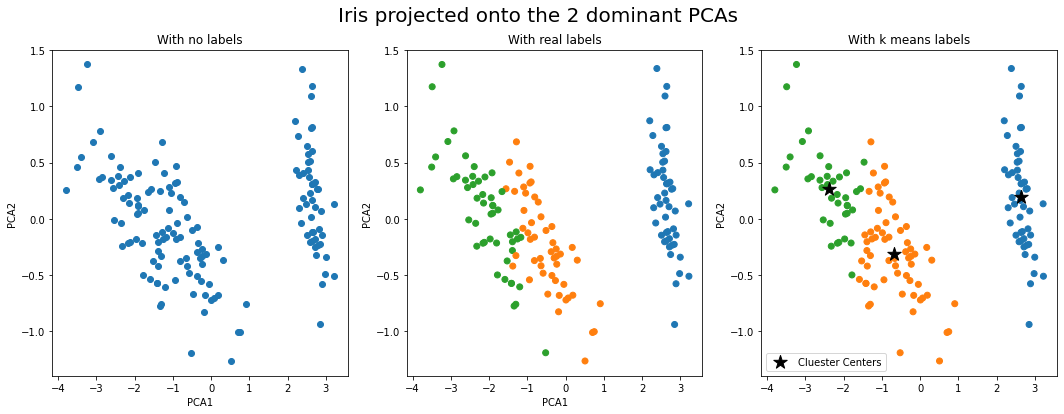

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle("Iris projected onto the 2 dominant PCAs", fontsize = 20)

Z_iris = pca.transform(X_iris)
ax1.scatter(Z_iris[:, 0], Z_iris[:, 1])
ax1.set_title("With no labels")
ax1.set_ylabel("PCA2"); ax1.set_xlabel("PCA1")

ax2.scatter(Z_iris[:, 0], Z_iris[:, 1], color = y_iris_colors)
ax2.set_title("With real labels")
ax2.set_ylabel("PCA2"); ax2.set_xlabel("PCA1")

pca_centers = pca.transform(kmeans.cluster_centers)
ax3.scatter(Z_iris[:, 0], Z_iris[:, 1], color = Y_kmeans_colors)
a = ax3.scatter(pca_centers[:, 0], pca_centers[:, 1], color = "black", s = 200, marker = "*", label = "Cluester Centers")
ax3.set_title("With k means labels")
ax3.set_ylabel("PCA2"); ax2.set_xlabel("PCA1")
ax3.legend()

### Experiment 2 (MNIST)

Below, we will use PCA to reduce the dimensions of the MNIST ([link to dataset](https://github.com/jytan17/miscellaneous/tree/main/other/data_ml_package_ng))dataset with a relatively large number of features (784 to be exact). This is a helpful preprocessing stage if we want to use k-means clustering as it does not work well with high dimensional data.

Note: this is not considered as a form of feature selection as we are transforming high dimensional data into a relatively lower dimension.

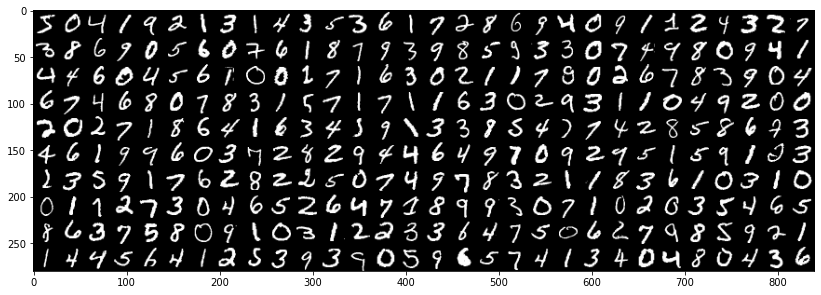

In [17]:
MNIST = np.load("mnist.npz")
mnist_images = MNIST['X']

def make_img_grid(images, n_cols=10):
    """ Helper function for arranging images into a grid """
    cols = []
    gap = len(images) % n_cols
    if gap > 0:
        # add padding if needed
        images = np.concatenate((images, np.zeros((n_cols-gap,)+images[0].shape)), 0)
    for n in range(n_cols):
        cols.append(np.concatenate(images[np.arange(n, len(images), step=n_cols)]))
    return np.concatenate(cols, -1)

plt.figure(figsize=(14,7))
plt.imshow(make_img_grid(mnist_images[:300], n_cols=30), cmap='binary_r');

Below is a plot to help us determine how many PCAs we should use for k-means. The visualization shows how much variance each PCA is able to capture, therefore, for PCAs with low values, it may be considered as irrelevant and we can safely neglect them for the next stage.

Text(0, 0.5, 'Explained variance')

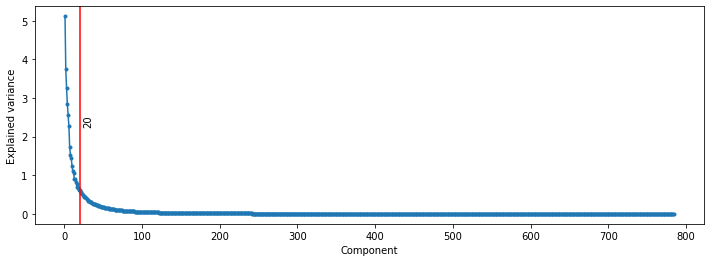

In [31]:
X_mnist = mnist_images.reshape(-1, 784) # reshape to 2d matrix

x_bar = X_mnist.mean(axis = 0)
X_tilde = X_mnist - x_bar


# this line workds out the pca's of the dataset along with some other values.
u, s, w = np.linalg.svd(X_tilde, full_matrices = False)

N, data_dim = X_mnist.shape
plt.figure(figsize=(12,4))
plt.plot(np.arange(data_dim)+1, s**2 / N, '.-')
plt.axvline(x=20, color = "red")
plt.text(25,2.3,'20', rotation = 90)
plt.xlabel('Component')
plt.ylabel('Explained variance')

From the table above, we can see that most of the variance are explained by the first 20 (ish) PCAs. Therefore, we can expect the k-means to do well with around 20 PCAs.

Now, we perform k means clustering on the MNIST dataset using the dimension reduced version. We set can let k be an arbitrary number here, but we know there are exactly 10 groups in our dataset. However, in PCA we normally do not know the actual number of groups, therefore we will try k = 15.


In [19]:
pca = PCA(20) # use only the first 20 PCA
pca.fit(X_mnist)
X_mnist_pca = pca.transform(X_mnist)

kmeans = kMeans(15) # we will cluster the data into 2 groups
kmeans.fit(X_mnist_pca)
z_mnist = kmeans.predict(X_mnist_pca)

Let us plot the a sample of each cluster to see how well k-means managed to cluster the data with the dimension reduced MNIST dataset.

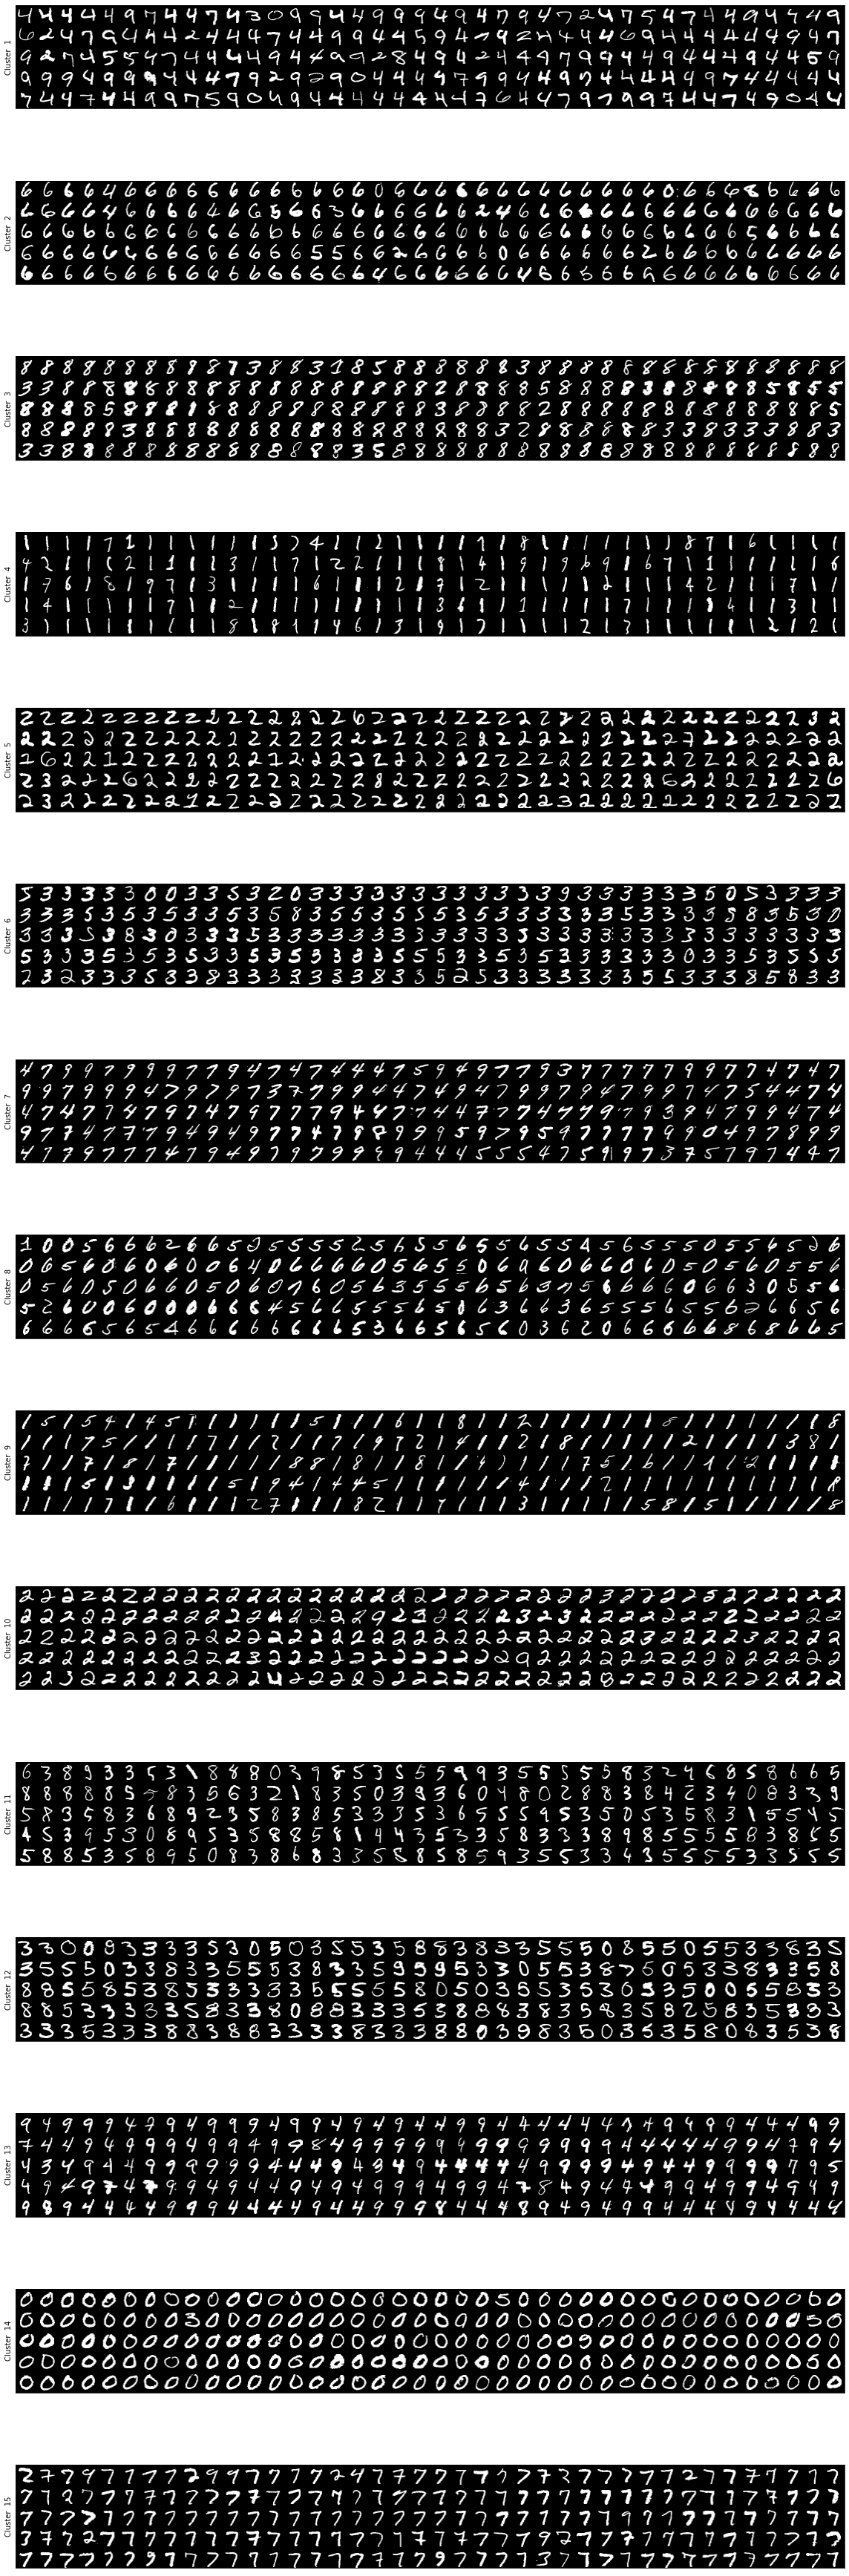

In [20]:
plt.figure(figsize=(16, 50))
for k in range(15):
    plt.subplot(15, 1, k+1)
    plt.imshow(make_img_grid(mnist_images[z_mnist==k][:200], n_cols=40), cmap='binary_r');
    plt.xticks([])
    plt.yticks([])
    plt.ylabel(f"Cluster  {k+1}")
plt.tight_layout();

Another interesting thing we can do is to plot the mean (center) of each cluster. We first project the 20 dimensional centers back into its original 784 dimension using the inverse pca transform, then plot it as an image.

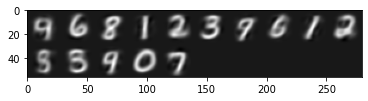

In [21]:
centers = kmeans.cluster_centers
mu_mnist = pca.inverse_transform(centers)
plt.imshow(make_img_grid(mu_mnist.reshape(15,28,28)), cmap='binary_r');

We get the a number for each cluster! Albeit a not so high def. one.

## Support Vector Machine




Below, we will generate some artificial datasets to test our implementations of the primal support vector machine (SVM) and kernelised SVM.

There will be two types of data, one linearly separable and another non-linearly separable. In the non-linearly separable case, the primal SVM will fail, thus requiring a more sophisticated technique (kernels) which involves projecting the data into a higher dimension for which the data is linearly separable.

In [22]:
# import the models from our package
from models.supervised import primalSVM, kernelSVM

# import other libraries
import numpy as np
import matplotlib.pyplot as plt
from numpy.matlib import repmat

In [23]:
def gen_linear_data(n=100,b=0.):
    "Generate a 2D linearly separable dataset, i.e. a dataset that can be separated by a line"
    
    xTr = np.random.randn(n, 2)
    w0 = np.random.rand(2, 1) # this is the separating hyperplane (line)
    yTr = np.sign(np.dot(xTr, w0)+b).flatten() # assign labels to point sin xTr based on their position on the 2D plane w.r.t. the line
    return xTr, yTr

def gen_spiral_data(N=300):
    "Generate a 2D non-linearly separable dataset"

    r = np.linspace(1,2*np.pi,N)
    xTr1 = np.array([np.sin(2.*r)*r, np.cos(2*r)*r]).T
    xTr2 = np.array([np.sin(2.*r+np.pi)*r, np.cos(2*r+np.pi)*r]).T
    xTr = np.concatenate([xTr1, xTr2], axis=0)
    yTr = np.concatenate([np.ones(N), -1 * np.ones(N)])
    xTr = xTr + np.random.randn(xTr.shape[0], xTr.shape[1])*0.2
    
    xTe = xTr[::2,:]
    yTe = yTr[::2]
    xTr = xTr[1::2,:]
    yTr = yTr[1::2]
    
    return xTr,yTr,xTe,yTe

def visualize_svm(model, arrow = True):
    "A helper function to visualise out SVM's solution"

    Xtr, ytr = model.xTr, model.yTr
    symbols = ["ko", "kx"]
    marker_symbols = ['o', 'x']
    mycolors = [[0.5, 0.5, 1], [1, 0.5, 0.5]]
    labels = np.unique(ytr)

    res = 300
    x = np.linspace(Xtr[:, 0].min(), Xtr[:, 0].max(), res)
    y = np.linspace(Xtr[:, 1].min(), Xtr[:, 1].max(), res)

    X = repmat(x, res, 1)
    Y = repmat(y, res, 1).T
    Xte = np.array([X.flatten(), Y.flatten()]).T

    preds = model.predict(Xte)
    Z = preds.reshape(res, res)

    plt.contourf(X, Y, np.sign(Z), colors = mycolors)
    
    for idx, c in enumerate(labels):
        plt.scatter(Xtr[ytr == c, 0], 
                    Xtr[ytr == c, 1], 
                    marker=marker_symbols[idx], 
                    color='k')
    
    if arrow:
        w, b = model.coef_, model.intercept_

        alpha = - 1 * b / (w**2).sum() 
        plt.quiver(
            w[0]*alpha,
            w[1]*alpha,
            w[0],
            w[1],
            linewidth=2,
            color=[0,1,0]
            )
        
    plt.axis('tight')
    plt.show()
    

Visualisation of the two datesets. As you can see, the table on the right looks separable by a straight line but the spiral dataset is not.

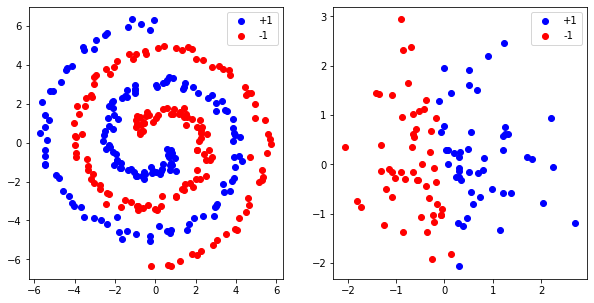

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))

xTr1,yTr1,xTe1,yTe1=gen_spiral_data()
xTr2,yTr2 = gen_linear_data()
ax1.scatter(xTr1[yTr1 == 1, 0], xTr1[yTr1 == 1, 1], c='b')
ax1.scatter(xTr1[yTr1 != 1, 0], xTr1[yTr1 != 1, 1], c='r')
ax1.legend(["+1","-1"])

ax2.scatter(xTr2[yTr2 == 1, 0], xTr2[yTr2 == 1, 1], c='b')
ax2.scatter(xTr2[yTr2 != 1, 0], xTr2[yTr2 != 1, 1], c='r')
ax2.legend(["+1", "-1"])


### Primal SVM 

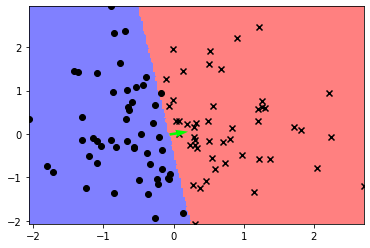

In [25]:
clf2 = primalSVM(C=10)
clf2.fit(xTr2, yTr2)
visualize_svm(clf2)

Primal SVM is unable to capture non linear patterns

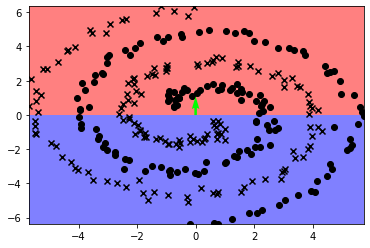

In [26]:
clf1= primalSVM(C=10)
clf1.fit(xTr1, yTr1)
visualize_svm(clf1)

In this case, we use a kernelised SVM (only the rbf kernel is supported now)

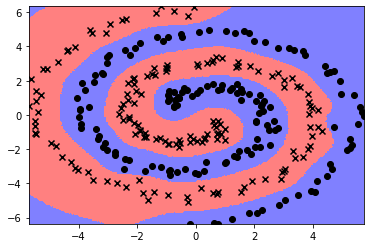

In [27]:
clf1= kernelSVM(10, "rbf", 1)
clf1.fit(xTr1, yTr1)
visualize_svm(clf1, False)

Furthermore, we can also use the kernelised SVM on the linearly separable data!

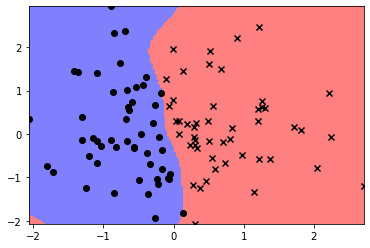

In [28]:
clf2= kernelSVM(10, "rbf", 1)
clf2.fit(xTr2, yTr2)
visualize_svm(clf2, False)

## Feedforward Network

Below we will test our implementation of a basic feed forward neural network on the MNIST dataset.

The mnist dataset is taken from the "sample_data" on google colab. Thus, running this section on google colab will automatically load the data without the need to download it. However, if you want to run this locally, please download the data from [Colab](https://colab.research.google.com/).

We will start by preprocessing the data by one hot encoding the labels and normalizing the data.

In [29]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, Normalizer
from sklearn.model_selection import train_test_split

mnist = pd.read_csv("/content/sample_data/mnist_train_small.csv").values
X, y = mnist[:, 1:], mnist[:, 0]

ohe = OneHotEncoder()
ohe.fit(y.reshape(-1, 1))
normalizer = Normalizer()
normalizer.fit(X)
X = normalizer.transform(X)
y = ohe.transform(y.reshape(-1, 1)).toarray()

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size = .2)
Xtr, Xva, ytr, yva = train_test_split(Xtr, ytr, test_size=.1)

We trained the network for 30 epochs with a mini batch size of 50 and a learning rate of 3.

In [30]:
from models.supervised import FeedForward
net = FeedForward([784, 30, 10])
net.fit(Xtr, ytr, 30, 10, 3.0, Xva, yva)
print("Predictions:",net.predict(Xte),"\nTruth labels:",ohe.inverse_transform(yte).flatten())

Epoch 0 validation acc. 1358 / 1600
Epoch 1 validation acc. 1415 / 1600
Epoch 2 validation acc. 1439 / 1600
Epoch 3 validation acc. 1452 / 1600
Epoch 4 validation acc. 1463 / 1600
Epoch 5 validation acc. 1464 / 1600
Epoch 6 validation acc. 1466 / 1600
Epoch 7 validation acc. 1467 / 1600
Epoch 8 validation acc. 1483 / 1600
Epoch 9 validation acc. 1471 / 1600
Epoch 10 validation acc. 1480 / 1600
Epoch 11 validation acc. 1485 / 1600
Epoch 12 validation acc. 1495 / 1600
Epoch 13 validation acc. 1493 / 1600
Epoch 14 validation acc. 1488 / 1600
Epoch 15 validation acc. 1492 / 1600
Epoch 16 validation acc. 1497 / 1600
Epoch 17 validation acc. 1501 / 1600
Epoch 18 validation acc. 1500 / 1600
Epoch 19 validation acc. 1499 / 1600
Epoch 20 validation acc. 1497 / 1600
Epoch 21 validation acc. 1498 / 1600
Epoch 22 validation acc. 1500 / 1600
Epoch 23 validation acc. 1503 / 1600
Epoch 24 validation acc. 1498 / 1600
Epoch 25 validation acc. 1495 / 1600
Epoch 26 validation acc. 1514 / 1600
Epoch 27 va